In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:

import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import math
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.graphics.tsaplots import plot_pacf

In [3]:
df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
df.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [4]:
def shape(dataframe):
    print('='*20,'DATAFRAME SHAPE','='*20)
    print('Dataframe has {} rows and {} columns'.format(dataframe.shape[0],dataframe.shape[1]))
    print('\n')

def info(dataframe):
    print('='*20,'Dataframe Info','='*20)
    display(dataframe.info())
    print('\n')
    
def describe(dataframe):
    print('='*20,'Dataframe Describe','='*20)
    display(dataframe.describe().T)
    print('\n')
    
def missing_unique_values(dataframe):
    missing = pd.DataFrame({'Name':dataframe.columns,
                            'Unique':[dataframe[col].nunique() for col in df.columns],
                            'Missing': [dataframe[col].isna().sum() for col in dataframe.columns]})
    missing = missing.sort_values(by='Missing',ascending=False).reset_index(drop=True)
    return missing

shape(df)
info(df)
describe(df)
missing_unique_values(df)
    

==================== DATAFRAME SHAPE ====================
Dataframe has 1218 rows and 2 columns


==================== Dataframe Info ====================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


None



==================== Dataframe Describe ====================


,count,mean,std,min,25%,50%,75%,max
dcoilwtico,1175.0,67.714366,25.630476,26.19,46.405,53.19,95.66,110.62


,Name,Unique,Missing
0,dcoilwtico,998,43
1,date,1218,0


In [5]:
df = df.rename(columns={'dcoilwtico':'Price'})
df['date'] = pd.to_datetime(df['date'])

In [6]:
df.set_index('date',inplace=True)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:black;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;
              text-align:center;">
                            Backword Fill to fill the missing values
              
</p>
</div>

<AxesSubplot:title={'center':'Oil Prices'}, xlabel='date'>

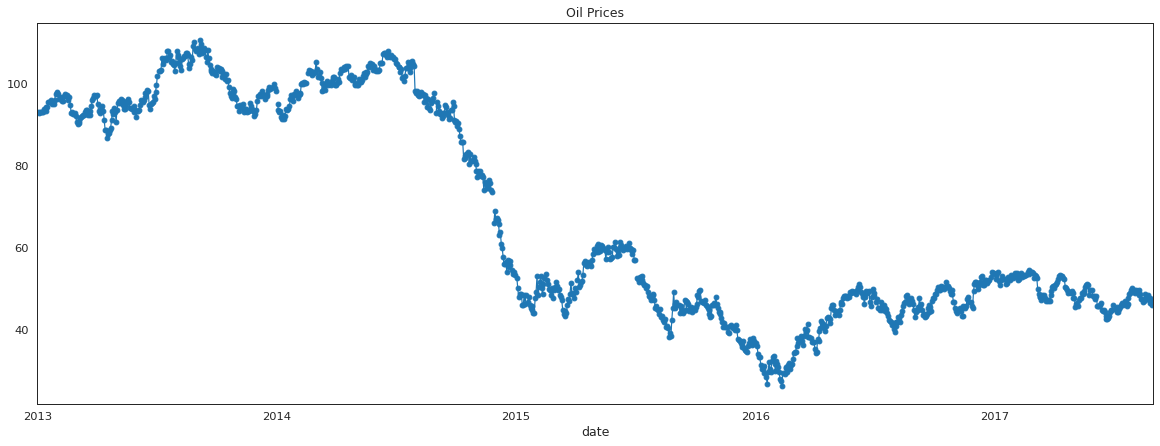

In [7]:
df['Price'].plot(title='Oil Prices',marker='o',figsize=(20,7))

<AxesSubplot:title={'center':'Oil Price'}, xlabel='date'>

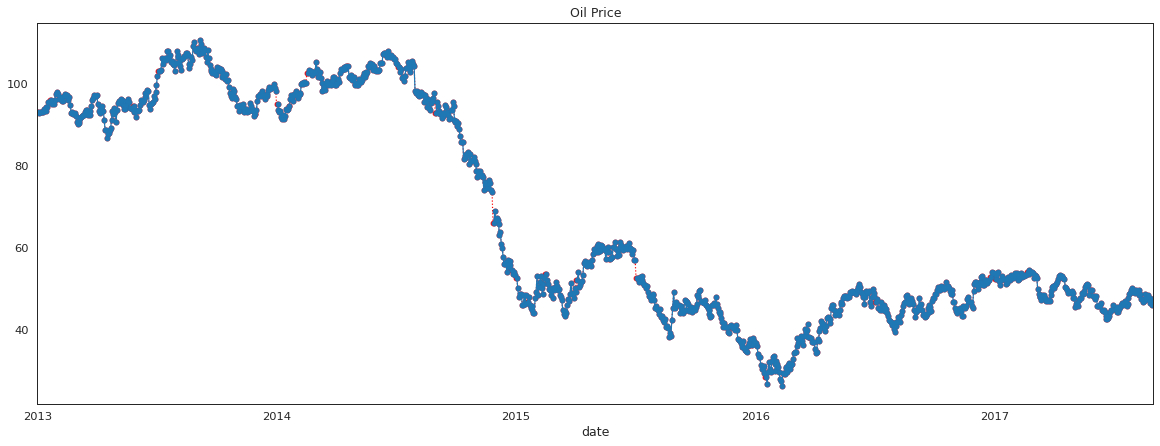

In [8]:
bfill_imp = df.fillna(method='bfill')
bfill_imp['Price'].plot(color='red', marker='o', linestyle='dotted')
df['Price'].plot(title='Oil Price', marker='o',figsize=(20,7))

In [9]:
df = df.fillna(method = 'bfill')
df = df.reset_index()
df = df.sort_values('date')
df.set_index('date',inplace=True)

In [10]:
df.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-07', '2013-01-08', '2013-01-09', '2013-01-10',
               '2013-01-11', '2013-01-14',
               ...
               '2017-08-18', '2017-08-21', '2017-08-22', '2017-08-23',
               '2017-08-24', '2017-08-25', '2017-08-28', '2017-08-29',
               '2017-08-30', '2017-08-31'],
              dtype='datetime64[ns]', name='date', length=1218, freq=None)

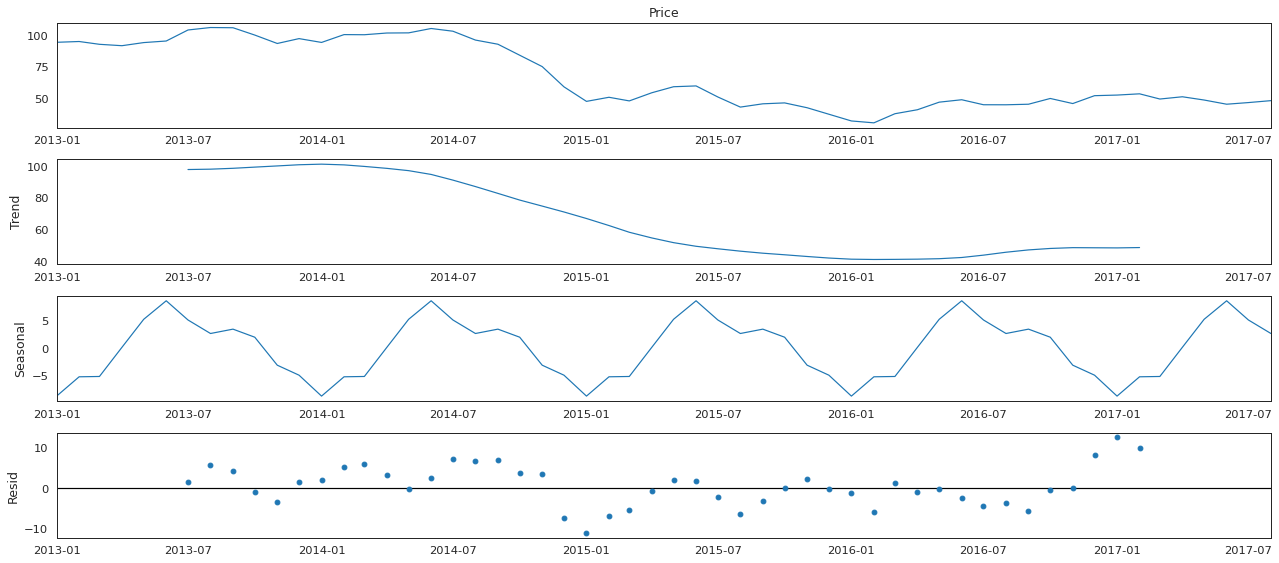

In [11]:
y = df['Price'].resample('MS').mean()
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:black;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;
              text-align:center;">
                            Convert the array values into dataset matirx
              
</p>


In [12]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back-1):
                a = dataset[i:(i+look_back), 0]
                dataX.append(a)
                dataY.append(dataset[i + look_back, 0])
    
    return np.array(dataX), np.array(dataY)
    

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:black;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;
              text-align:center;">
                            Using MinMax scaler for feature scaling
              
</p>


In [13]:
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(df)
df[:3]

array([[0.79296459],
       [0.79296459],
       [0.79095108]])

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:black;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;
              text-align:center;">
                            Split the dataset into train and test set
              
</p>


In [14]:
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size

train, test = df[0:train_size,:], df[train_size:len(df),:]

train.shape

(852, 1)

In [15]:
test.shape

(366, 1)

In [16]:
look_back = 90

xtrain, ytrain = create_dataset(train, look_back)
xtest, ytest = create_dataset(test, look_back)

In [17]:
xtrain = np.reshape(xtrain, (xtrain.shape[0], 1, xtrain.shape[1]))
xtest = np.reshape(xtest, (xtest.shape[0], 1, xtest.shape[1]))

In [18]:
xtrain.shape

(761, 1, 90)

In [19]:
xtest.shape

(275, 1, 90)

In [20]:
print('xtrain shape is {}'.format(xtrain.shape))
print('ytrain shape is {}'.format(ytrain.shape))
print('xtest shape is {}'.format(xtest.shape))
print('ytest shape is {}'.format(ytest.shape))

xtrain shape is (761, 1, 90)
ytrain shape is (761,)
xtest shape is (275, 1, 90)
ytest shape is (275,)


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:black;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;
              text-align:center;">
                            Create & fit LSTM Bidirectional Network
              
</p>
</div>

In [21]:
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(100,1))))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

2022-10-02 18:12:59.586577: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [22]:
model.fit(xtrain, ytrain, epochs=200, batch_size=5, verbose=2)

2022-10-02 18:12:59.760892: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200
153/153 - 4s - loss: 0.0164
Epoch 2/200
153/153 - 0s - loss: 0.0027
Epoch 3/200
153/153 - 0s - loss: 0.0018
Epoch 4/200
153/153 - 0s - loss: 0.0016
Epoch 5/200
153/153 - 0s - loss: 0.0016
Epoch 6/200
153/153 - 0s - loss: 0.0012
Epoch 7/200
153/153 - 0s - loss: 0.0013
Epoch 8/200
153/153 - 0s - loss: 0.0010
Epoch 9/200
153/153 - 0s - loss: 0.0013
Epoch 10/200
153/153 - 0s - loss: 8.9700e-04
Epoch 11/200
153/153 - 0s - loss: 0.0012
Epoch 12/200
153/153 - 0s - loss: 9.4659e-04
Epoch 13/200
153/153 - 0s - loss: 0.0014
Epoch 14/200
153/153 - 0s - loss: 0.0015
Epoch 15/200
153/153 - 0s - loss: 0.0011
Epoch 16/200
153/153 - 0s - loss: 0.0011
Epoch 17/200
153/153 - 0s - loss: 7.8959e-04
Epoch 18/200
153/153 - 0s - loss: 7.5493e-04
Epoch 19/200
153/153 - 0s - loss: 7.3077e-04
Epoch 20/200
153/153 - 0s - loss: 8.2358e-04
Epoch 21/200
153/153 - 0s - loss: 7.1639e-04
Epoch 22/200
153/153 - 0s - loss: 6.5978e-04
Epoch 23/200
153/153 - 0s - loss: 6.3194e-04
Epoch 24/200
153/153 - 0s - lo

In [23]:
monitor = EarlyStopping(monitor = 'val_loss', min_delta=1e-3, patience=30,
                       verbose=1,mode='auto',restore_best_weights=True)

history1=model.fit(xtrain,ytrain,validation_data=(xtest,ytest),
        callbacks=[monitor],verbose=1,epochs=100)

Epoch 1/100
24/24 [==============================] - 1s 25ms/step - loss: 2.6126e-04 - val_loss: 2.4591e-04
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 2.5009e-04 - val_loss: 2.8958e-04
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 2.4612e-04 - val_loss: 2.5164e-04
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 2.5910e-04 - val_loss: 2.7991e-04
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - loss: 2.4414e-04 - val_loss: 2.6227e-04
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - loss: 2.6696e-04 - val_loss: 2.6630e-04
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - loss: 2.4817e-04 - val_loss: 2.6393e-04
Epoch 8/100
24/24 [==============================] - 0s 5ms/step - loss: 2.5508e-04 - val_loss: 2.3851e-04
Epoch 9/100
24/24 [==============================] - 0s 5ms/step - loss: 2.4231e-04 - val_loss: 2.7387e-04
Epoch 10/100
24/24 [================

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 200)               152800    
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 153,001
Trainable params: 153,001
Non-trainable params: 0
_________________________________________________________________


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:black;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;
              text-align:center;">
                            Make Prediction
              
</p>
</div>

In [25]:
train_pred = model.predict(xtrain)
test_pred = model.predict(xtest)

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:black;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;
              text-align:center;">
                            Invert Prediction
              
</p>
</div>

In [26]:
train_pred = scaler.inverse_transform(train_pred)
ytrain = scaler.inverse_transform([ytrain])
test_pred = scaler.inverse_transform(test_pred)
ytest = scaler.inverse_transform([ytest])

<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:black;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;
              text-align:center;">
                            Calculate the root mean squared error
              
</p>
</div>

In [27]:
trainScore = math.sqrt(mean_squared_error(ytrain[0], train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(ytest[0], test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.32 RMSE
Test Score: 1.32 RMSE


In [28]:
print('Train Mean Absolute Error:', mean_absolute_error(ytrain[0], train_pred[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(ytrain[0], train_pred[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(ytest[0], test_pred[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ytest[0], test_pred[:,0])))

Train Mean Absolute Error: 1.005800187540743
Train Root Mean Squared Error: 1.3244135267957868
Test Mean Absolute Error: 1.0315960521351208
Test Root Mean Squared Error: 1.3239788194027398


<div style="color:white;
           display:fill;
           border-radius:5px;
           background-color:black;
           font-size:110%;
           font-family:Verdana;
           letter-spacing:0.5px">

<p style="padding: 10px;
              color:white;
              text-align:center;">
                            Plot Actual VS Predicted Values
              
</p>
</div>

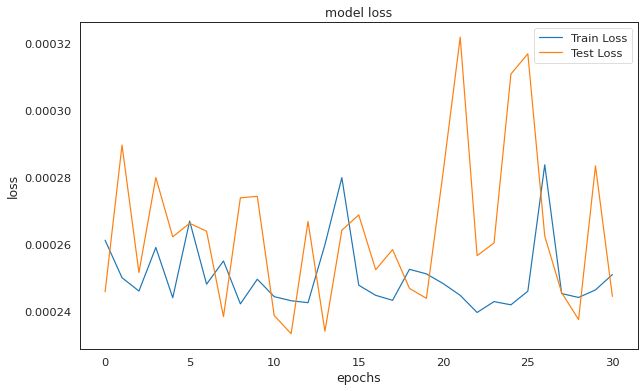

In [29]:
plt.figure(figsize=(10,6))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

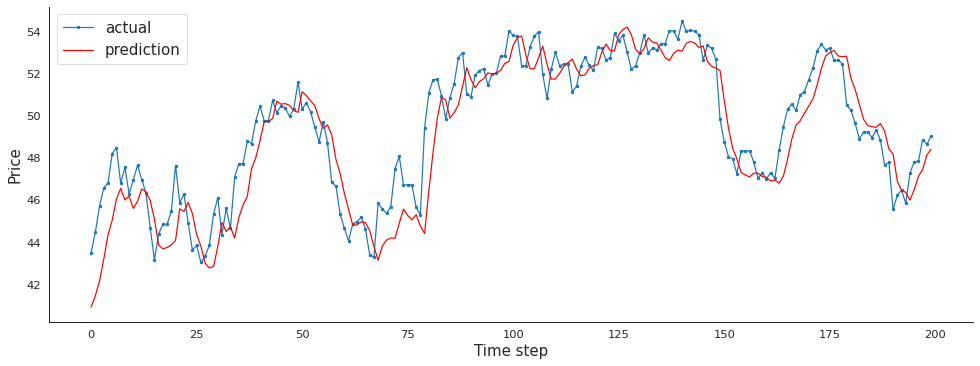

In [30]:
aa=[x for x in range(200)]
plt.figure(figsize=(14,5))
plt.plot(aa, ytest[0][:200], marker='.', label="actual")
plt.plot(aa, test_pred[:,0][:200], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();